# Detección de Anomalías en Señales de Vibración

Este notebook implementa la detección de anomalías usando modelos de una clase, que aprenden el patrón de comportamiento normal de las señales de vibración.

## Pasos:
1. Cargar y preprocesar señales normales
2. Extraer características usando el extractor del dominio temporal
3. Entrenar y comparar diferentes modelos de detección de anomalías
4. Evaluar y guardar el mejor modelo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from tqdm.notebook import tqdm

# Módulos de scikit-learn para detección de anomalías
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

# Importar módulos propios
import sys
sys.path.append('..')
from vibration_analysis.preprocessing.signal_processing import SignalProcessor
from vibration_analysis.features.time_domain import TimeFeatureExtractor

## 1. Cargar y Preprocesar Señales

Cargamos las señales normales y aplicamos el preprocesamiento básico.

### Canales separados

In [8]:
# Configuración
DATA_DIR = Path('../data/normales')
FS = 1600.0  # Frecuencia de muestreo

def load_signal(file_path):
    """Carga una señal desde un archivo CSV."""
    return pd.read_csv(file_path, header=None).values

# Cargar todas las señales normales
signal_files = glob.glob(str(DATA_DIR / '**' / '*.csv'), recursive=True)
print(f"Encontrados {len(signal_files)} archivos de señales normales")

# Inicializar procesadores
signal_processor = SignalProcessor()
feature_extractor = TimeFeatureExtractor()

# Lista para almacenar características
features_list = []

for file in tqdm(signal_files, desc="Procesando señales"):
    signal = load_signal(file)
    
    # Procesar cada canal por separado, el procesador admite multicanal. (Es un ejemplo)
    for channel in range(signal.shape[1]):
        # Preprocesamiento
        processed = signal_processor.remove_dc(signal[:, channel])
        #processed = signal_processor.normalize(processed)
        
        # Extraer características
        features = feature_extractor.extract(processed)
        features['file'] = Path(file).name
        features['channel'] = channel
        features_list.append(features)

# Crear DataFrame con características
features_df = pd.DataFrame(features_list)
print("\nCaracterísticas extraídas:")
features_df.head()

Encontrados 268 archivos de señales normales


Procesando señales:   0%|          | 0/268 [00:00<?, ?it/s]


Características extraídas:


,std,var,rms,peak,peak_to_peak,kurtosis,skewness,crest_factor,file,channel
0,3.694532,13.649566,3.694532,12.330769,24.0,0.469103,0.407353,3.337573,0000.csv,0
1,3.138135,9.847890,3.138135,15.292308,24.0,2.546280,1.380928,4.873056,0000.csv,1
2,5.039966,25.401256,5.039966,19.505128,34.0,1.133420,0.743333,3.870091,0000.csv,2
3,3.610558,13.036128,3.610558,11.371795,22.0,0.122824,0.321074,3.149595,0001.csv,0
4,3.256482,10.604675,3.256482,13.161538,22.0,1.562530,1.278485,4.041643,0001.csv,1


In [3]:
# Ejemplo de filtrado por canal
features_df_ch0 = features_df[features_df['channel'] == 0]
features_df_ch0

,std,var,rms,peak,peak_to_peak,kurtosis,skewness,crest_factor,file,channel
0,3.694532,13.649566,3.694532,12.330769,24.0,0.469103,0.407353,3.337573,0000.csv,0
3,3.610558,13.036128,3.610558,11.371795,22.0,0.122824,0.321074,3.149595,0001.csv,0
6,3.820010,14.592479,3.820010,15.533333,26.0,0.622538,0.499766,4.066307,0002.csv,0
9,3.751225,14.071690,3.751225,13.343590,24.0,0.339811,0.343653,3.557129,0003.csv,0
12,3.787397,14.344379,3.787397,13.615385,24.0,0.526750,0.455489,3.594918,0004.csv,0
...,...,...,...,...,...,...,...,...,...,...
789,68.180954,4648.642498,68.180954,240.651282,474.0,0.274529,-0.083136,3.529597,0024.csv,0
792,76.143373,5797.813248,76.143373,252.833333,440.0,-0.191921,0.152260,3.320490,0025.csv,0
795,65.150445,4244.580533,65.150445,190.715385,352.0,-0.613807,-0.064827,2.927307,0026.csv,0
798,34.078990,1161.377587,34.078990,173.110256,328.0,3.729988,0.100837,5.079677,0027.csv,0


### Canales combinados

Igual que lo anterior, solo se utiliza el procesador para combinar características multicanal

In [4]:
# Configuración
DATA_DIR = Path('../data/normales')
FS = 1600.0  # Frecuencia de muestreo

def load_signal(file_path):
    """Carga una señal desde un archivo CSV."""
    return pd.read_csv(file_path, header=None).values

# Cargar todas las señales normales
signal_files = glob.glob(str(DATA_DIR / '**' / '*.csv'), recursive=True)
print(f"Encontrados {len(signal_files)} archivos de señales normales")

# Inicializar procesadores
signal_processor = SignalProcessor()
feature_extractor = TimeFeatureExtractor()

# Lista para almacenar características
features_list = []

for file in tqdm(signal_files, desc="Procesando señales"):
    signal = load_signal(file)
    
    # Preprocesamiento
    processed = signal_processor.remove_dc(signal)
    #processed = signal_processor.normalize(processed)
    
    # Extraer características
    features = feature_extractor.extract(processed)
    features['file'] = Path(file).name
    features_list.append(features)

# Crear DataFrame con características
features_df = pd.DataFrame(features_list)
print("\nCaracterísticas extraídas:")
features_df.head()

Encontrados 268 archivos de señales normales


Procesando señales:   0%|          | 0/268 [00:00<?, ?it/s]


Características extraídas:


,std_x,var_x,rms_x,peak_x,peak_to_peak_x,kurtosis_x,skewness_x,crest_factor_x,std_y,var_y,...,crest_factor_z,std_combined,var_combined,rms_combined,peak_combined,peak_to_peak_combined,kurtosis_combined,skewness_combined,crest_factor_combined,file
0,3.694532,13.649566,90.255989,102.511111,24.0,0.469103,0.407353,1.135782,3.138135,9.847890,...,1.101218,3.957544,16.299570,128.052556,141.503704,27.333333,1.382934,0.843871,1.107340,0000.csv
1,3.610558,13.036128,89.896467,100.452137,22.0,0.122824,0.321074,1.117420,3.256482,10.604675,...,1.115103,3.983756,16.496728,127.689140,141.484046,26.000000,0.806956,0.732158,1.106315,0001.csv
2,3.820010,14.592479,89.978561,100.364103,26.0,0.622538,0.499766,1.115422,3.150007,9.922544,...,1.094741,3.854664,15.206544,127.687337,139.454701,26.666667,0.855215,0.702556,1.092282,0002.csv
3,3.751225,14.071690,89.971397,100.549573,24.0,0.339811,0.343653,1.117573,2.924129,8.550533,...,1.112170,3.881426,15.770806,127.966910,139.516524,24.666667,1.016689,0.737061,1.084890,0003.csv
4,3.787397,14.344379,90.200062,100.505128,24.0,0.526750,0.455489,1.114247,3.029258,9.176404,...,1.101798,3.931449,16.099397,127.989554,140.168376,25.333333,0.619844,0.656266,1.093920,0004.csv


## 2. Preparar Datos para Entrenamiento

In [9]:
# Separar características y metadatos
feature_columns = [col for col in features_df.columns if col not in ['file', 'channel']]
X = features_df[feature_columns].values

# Escalar características (ejemplo manual y tradicional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos para validación (ejemplo, conviene separar ensayos a nivel de directorios)
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

## 3. Entrenar y Comparar Modelos de Detección de Anomalías

Comparamos diferentes algoritmos de detección de anomalías:

In [26]:
# Apagar los warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Definir modelos a comparar
models = {
    'One-Class SVM': OneClassSVM(kernel='rbf', nu=0.1),
    'Isolation Forest': IsolationForest(contamination=0.1, random_state=42),
    'Local Outlier Factor': LocalOutlierFactor(novelty=True, contamination=0.1),
    'Robust Covariance': EllipticEnvelope(contamination=0.1, random_state=42)
}

# Entrenar y evaluar cada modelo
results = {}
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train)
    
    # Calcular scores
    if hasattr(model, 'score_samples'):
        train_scores = model.score_samples(X_train)
        val_scores = model.score_samples(X_val)
    else:
        train_scores = model.decision_function(X_train)
        val_scores = model.decision_function(X_val)
    
    results[name] = {
        'model': model,
        'train_scores': train_scores,
        'val_scores': val_scores
    }


Entrenando One-Class SVM...

Entrenando Isolation Forest...

Entrenando Local Outlier Factor...

Entrenando Robust Covariance...


## 4. Visualizar Distribución de Scores

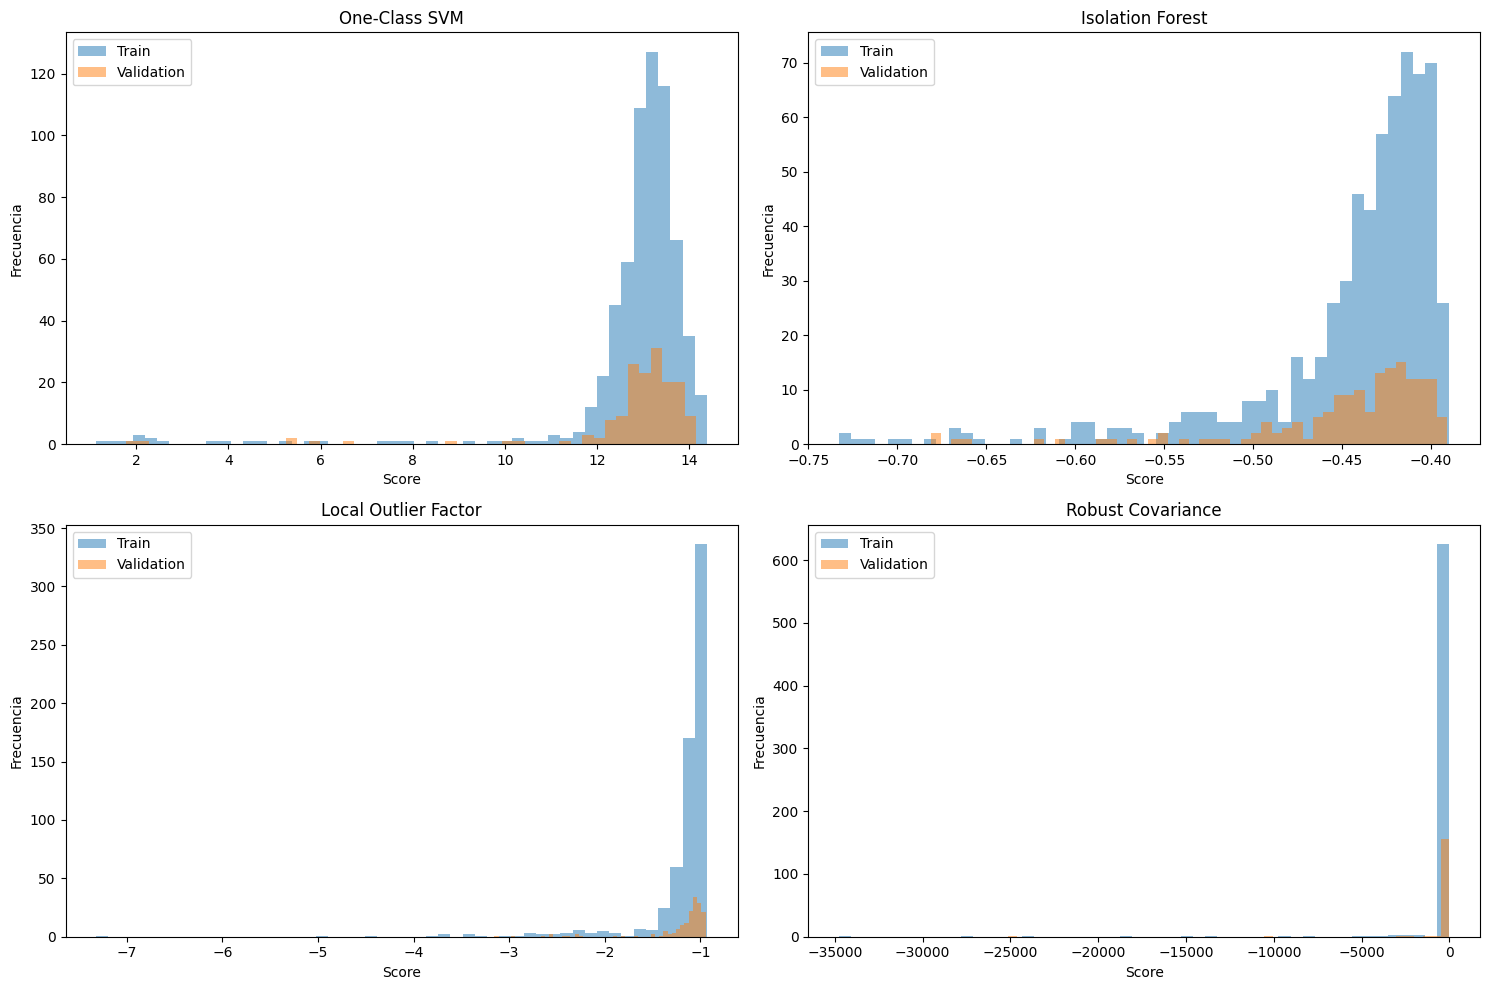

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    axes[i].hist(result['train_scores'], bins=50, alpha=0.5, label='Train')
    axes[i].hist(result['val_scores'], bins=50, alpha=0.5, label='Validation')
    axes[i].set_title(name)
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

plt.tight_layout()
plt.show()

## 5. Guardar Mejor Modelo

Basado en la distribución de scores y la interpretabilidad, seleccionamos y guardamos el mejor modelo.

In [12]:
import joblib
from pathlib import Path

# Crear directorio para modelos si no existe
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# Guardar el mejor modelo (ejemplo con Isolation Forest)
best_model = results['Isolation Forest']['model']
joblib.dump({
    'model': best_model,
    'scaler': scaler,
    'feature_columns': feature_columns
}, model_dir / 'anomaly_detector.joblib')

print("Modelo guardado exitosamente")

Modelo guardado exitosamente


## 6. Ejemplo de Uso del Modelo

Demostración de cómo usar el modelo guardado para detectar anomalías.

In [13]:
def predict_anomaly(signal, model_data):
    """Predice si una señal es anómala."""
    # Extraer características
    features = TimeFeatureExtractor().extract(signal)
    
    # Preparar features en el mismo orden
    X = np.array([[features[col] for col in model_data['feature_columns']]])
    
    # Escalar
    X_scaled = model_data['scaler'].transform(X)
    
    # Predecir
    return model_data['model'].predict(X_scaled)[0]

# Cargar modelo
model_data = joblib.load(model_dir / 'anomaly_detector.joblib')

# Ejemplo con una señal normal
test_signal = load_signal(signal_files[0])[:, 0]
result = predict_anomaly(test_signal, model_data)
print(f"Predicción para señal de prueba: {'Normal' if result == 1 else 'Anómala'}")

Predicción para señal de prueba: Normal


In [16]:
test_signal = load_signal(signal_files[20])[:, 0]
result = predict_anomaly(test_signal, model_data)
print(f"Predicción para señal de prueba: {'Normal' if result == 1 else 'Anómala'}")

Predicción para señal de prueba: Normal


In [17]:
# Configuración
DATA_ANOMAL_DIR = Path('../data/anormales')
FS = 1600.0  # Frecuencia de muestreo

def load_signal(file_path):
    """Carga una señal desde un archivo CSV."""
    return pd.read_csv(file_path, header=None).values

# Cargar todas las señales normales
signal_anomaly_files = glob.glob(str(DATA_ANOMAL_DIR / '**' / '*.csv'), recursive=True)
print(f"Encontrados {len(signal_anomaly_files)} archivos de señales anormales")

Encontrados 131 archivos de señales anormales


In [21]:
test_anomaly_signal = load_signal(signal_anomaly_files[20])[:, 0]
test_anomaly_signal = signal_processor.remove_dc(test_anomaly_signal)
result = predict_anomaly(test_anomaly_signal, model_data)
print(f"Predicción para señal de prueba: {'Normal' if result == 1 else 'Anómala'}")

Predicción para señal de prueba: Anómala


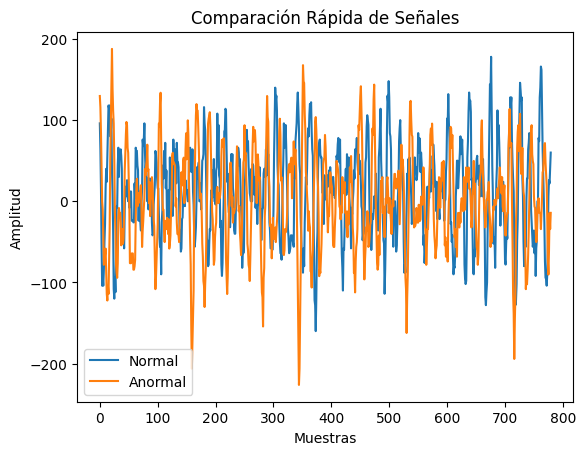

In [25]:
plt.plot(test_signal, label='Normal')
plt.plot(test_anomaly_signal, label='Anormal')
plt.title("Comparación Rápida de Señales")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.show()